In [1]:
from __future__ import absolute_import,division,print_function,unicode_literals
#importing the necessary libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys

# Add the directory containing the Python file to the `sys.path` list
sys.path.append("/IMP DOCUMENT/College material/SEM6/AIProject/Ozone-Prediction-AIProject/Support")

# Import the Python file
import LSTM_Model
import TsPreProcessing

In [3]:
data = pd.read_excel('AyaNagar_CombinedData.xlsx', sheet_name='Sheet1')
data.head()

,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,CO,Ozone
0,01-09-2017 00:00,02-09-2017 00:00,None,None,None,None,None,None,None
1,02-09-2017 00:00,03-09-2017 00:00,None,None,None,None,None,None,None
2,03-09-2017 00:00,04-09-2017 00:00,None,None,None,None,None,None,None
3,04-09-2017 00:00,05-09-2017 00:00,None,None,None,None,None,None,None
4,05-09-2017 00:00,06-09-2017 00:00,None,None,None,None,None,None,None


In [4]:
# Convert the date column to datetime
from datetime import datetime
df = data.copy()
# datae
df['From Date'] = df['From Date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
df['To Date'] = df['To Date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
df['From Date'].min(), df['From Date'].max()
df = df.set_index('To Date')
df.drop(['From Date'], axis=1, inplace=True)
df.head()

,PM2.5,PM10,NO,NO2,NOx,CO,Ozone
To Date,,,,,,,
2017-09-02,None,None,None,None,None,None,None
2017-09-03,None,None,None,None,None,None,None
2017-09-04,None,None,None,None,None,None,None
2017-09-05,None,None,None,None,None,None,None
2017-09-06,None,None,None,None,None,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2035 entries, 2017-09-02 00:00:00 to 2023-03-28 00:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PM2.5   2035 non-null   object
 1   PM10    2035 non-null   object
 2   NO      2035 non-null   object
 3   NO2     2035 non-null   object
 4   NOx     2035 non-null   object
 5   CO      2035 non-null   object
 6   Ozone   2035 non-null   object
dtypes: object(7)
memory usage: 127.2+ KB


In [7]:
# df.drop(['Temp'], axis=1, inplace=True)
num_cols = df.columns
num_cols

Index(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'Ozone'], dtype='object')

In [8]:
df = df.replace('None', np.nan)
# iterate through the columns and convert to float
for col in num_cols:
    df[col] = df[col].astype(float)


In [9]:
print("Rows  :  ",df.shape[0])
print("Columns : ",df.shape[1])
print("\nFeatures : \n",df.columns.tolist())

Rows  :   2035
Columns :  7

Features : 
 ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'Ozone']


In [10]:

print("\nMissing values : \n",df.isnull().any())


Missing values : 
 PM2.5    True
PM10     True
NO       True
NO2      True
NOx      True
CO       True
Ozone    True
dtype: bool


In [11]:
print("\nUnique values : \n",df.nunique())


Unique values : 
 PM2.5    1818
PM10     1899
NO       1357
NO2      1422
NOx      1638
CO        315
Ozone    1623
dtype: int64


# Visualizing The Data for Ashok Vihar

In [12]:
oz_data = df['Ozone']
oz_data.head()

To Date
2017-09-02   NaN
2017-09-03   NaN
2017-09-04   NaN
2017-09-05   NaN
2017-09-06   NaN
Name: Ozone, dtype: float64

<AxesSubplot:xlabel='To Date'>

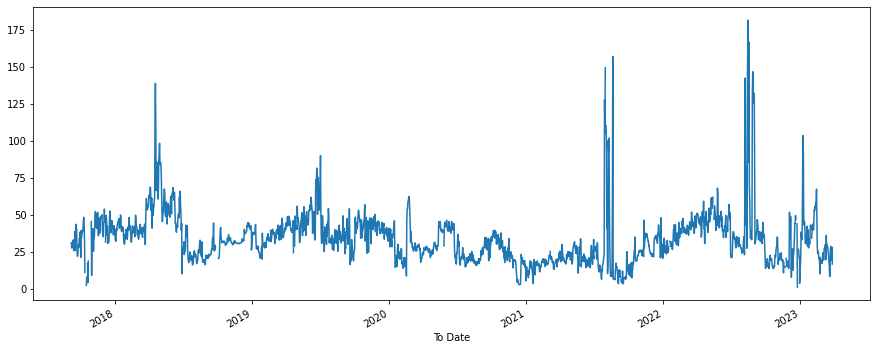

In [13]:
oz_data.plot(figsize=(15, 6))

In [14]:
import plotly.express as px
fig = px.line(oz_data, x=oz_data.index, y=oz_data.values, title='Ozone Concentration')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

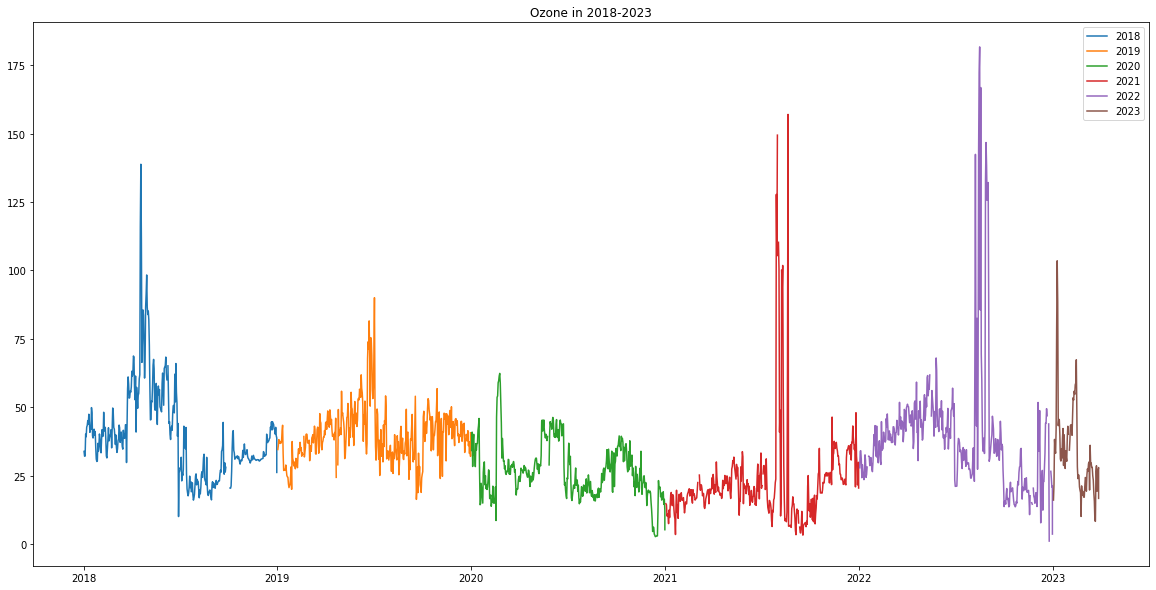

In [15]:

year = ['2018','2019','2020','2021','2022','2023']
# all plots in one figure
plt.figure(figsize=(20,10))
for i in year:
    df_year = df.loc[i]
    plt.plot(df_year['Ozone'],label=i)
plt.legend(loc='best')
plt.title('Ozone in 2018-2023')
plt.show()

In [20]:
# i want to group by month
aq_df = df.copy()
aq_df['month'] = df.index.month
aq_df['year'] = df.index.year
aq_df['day'] = df.index.day
aq_df.head()

,PM2.5,PM10,NO,NO2,NOx,CO,Ozone,month,year,day
To Date,,,,,,,,,,
2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2017,2
2017-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2017,3
2017-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2017,4
2017-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2017,5
2017-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2017,6


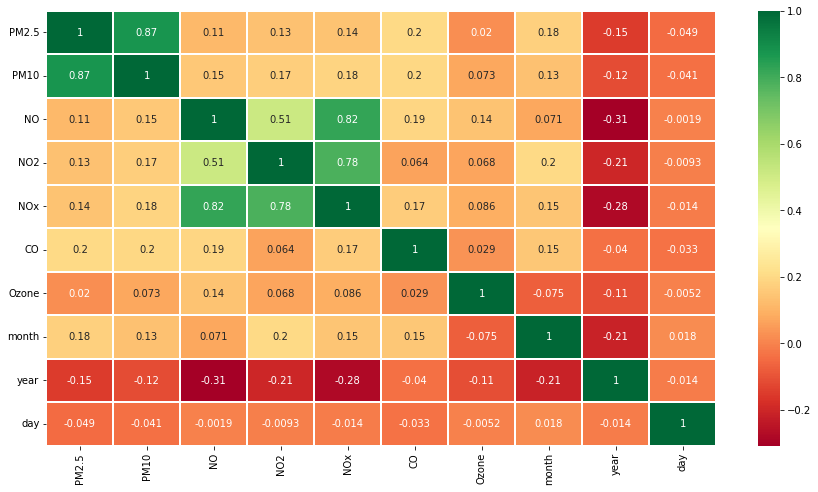

In [21]:
aq_df.dropna(inplace=True)
aq_corr = aq_df.corr(method='pearson')
g = sns.heatmap(aq_corr,annot=True,cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(15,8)
plt.show()

# LSTM Model Training for Ashok Vihar

In [22]:
# dropping the null values
aq_df.dropna(inplace=True)
aq_df.isnull().sum()

PM2.5    0
PM10     0
NO       0
NO2      0
NOx      0
CO       0
Ozone    0
month    0
year     0
day      0
dtype: int64

In [23]:
aq_df.head()

,PM2.5,PM10,NO,NO2,NOx,CO,Ozone,month,year,day
To Date,,,,,,,,,,
2017-09-08,51.65,97.00,24.56,19.56,44.13,1.26,27.44,9,2017,8
2017-09-09,43.45,80.57,24.66,19.66,44.32,1.27,28.91,9,2017,9
2017-09-10,70.70,139.33,24.37,19.37,43.74,1.25,29.58,9,2017,10
2017-09-11,46.42,89.83,24.77,19.77,44.55,1.28,30.43,9,2017,11
2017-09-12,53.91,106.56,23.93,18.94,42.87,1.22,32.97,9,2017,12


In [24]:
# define the train and test data
x_train = aq_df[:'2022-01-01']
y_train = x_train['Ozone']
x_test = aq_df['2022-01-01':]
y_test = x_test['Ozone']
print(y_test)

To Date
2022-01-02    27.83
2022-01-03    33.89
2022-01-04    34.07
2022-01-05    30.97
2022-01-06    24.20
              ...  
2023-03-25    19.26
2023-03-26    24.52
2023-03-27    26.99
2023-03-28    27.92
2023-03-28    16.64
Name: Ozone, Length: 440, dtype: float64


In [25]:
# transforming and normalizing the data
train_norm = TsPreProcessing.Transform_Normalize(x_train['Ozone'])
test_norm = TsPreProcessing.Transform_Normalize(x_test['Ozone'])

[0.16278018]
[0.17227569]
[0.17660358]
[0.18209418]
[0.19850139]
Number of null values in norm =  1
[0.14831212]
[0.18184837]
[0.18284449]
[0.16568899]
[0.12822357]
Number of null values in norm =  1


In [26]:
print(train_norm.shape)
print(test_norm.shape)

(1473,)
(439,)


In [27]:
n_steps = 15 #number of steps to look back
X_split_train, y_split_train = TsPreProcessing.split_sequence(train_norm, n_steps)
for i in range(len(X_split_train)):
    print(X_split_train[i], y_split_train[i])
n_features = 1 #number of features (in this case it is just the number of columns in the dataframe)
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))

[0.16278018 0.17227569 0.17660358 0.18209418 0.19850139 0.15263872
 0.23364124 0.15276791 0.2176216  0.26658485 0.23758155 0.24572056
 0.15399522 0.12660681 0.12983657] 0.16323234933143854
[0.17227569 0.17660358 0.18209418 0.19850139 0.15263872 0.23364124
 0.15276791 0.2176216  0.26658485 0.23758155 0.24572056 0.15399522
 0.12660681 0.12983657 0.16323235] 0.17660357858019507
[0.17660358 0.18209418 0.19850139 0.15263872 0.23364124 0.15276791
 0.2176216  0.26658485 0.23758155 0.24572056 0.15399522 0.12660681
 0.12983657 0.16323235 0.17660358] 0.16607454298817906
[0.18209418 0.19850139 0.15263872 0.23364124 0.15276791 0.2176216
 0.26658485 0.23758155 0.24572056 0.15399522 0.12660681 0.12983657
 0.16323235 0.17660358 0.16607454] 0.23254311736967898
[0.19850139 0.15263872 0.23364124 0.15276791 0.2176216  0.26658485
 0.23758155 0.24572056 0.15399522 0.12660681 0.12983657 0.16323235
 0.17660358 0.16607454 0.23254312] 0.21258316646211484
[0.15263872 0.23364124 0.15276791 0.2176216  0.26658485 

In [28]:
X_split_test, y_split_test = TsPreProcessing.split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))


[0.14831212 0.18184837 0.18284449 0.16568899 0.12822357 0.15439956
 0.13846154 0.13132263 0.12429441 0.14360819 0.1744881  0.16358605
 0.12888766 0.13491976 0.14980631] 0.17172108467072497
[0.18184837 0.18284449 0.16568899 0.12822357 0.15439956 0.13846154
 0.13132263 0.12429441 0.14360819 0.1744881  0.16358605 0.12888766
 0.13491976 0.14980631 0.17172108] 0.17127836192584395
[0.18284449 0.16568899 0.12822357 0.15439956 0.13846154 0.13132263
 0.12429441 0.14360819 0.1744881  0.16358605 0.12888766 0.13491976
 0.14980631 0.17172108 0.17127836] 0.15285002767017156
[0.16568899 0.12822357 0.15439956 0.13846154 0.13132263 0.12429441
 0.14360819 0.1744881  0.16358605 0.12888766 0.13491976 0.14980631
 0.17172108 0.17127836 0.15285003] 0.15478693967902601
[0.12822357 0.15439956 0.13846154 0.13132263 0.12429441 0.14360819
 0.1744881  0.16358605 0.12888766 0.13491976 0.14980631 0.17172108
 0.17127836 0.15285003 0.15478694] 0.16912008854454896


In [29]:
# import the fucntion for Support folder from the same directory
from LSTM_Model import build_lstm_model
n_steps = 15
n_features = 1
input_shape = (n_steps, n_features)
num_lstm_units = 64
num_hidden_layers = 2
num_units_hidden_layers = 32
activation_function = 'tanh'
dropout_rate = 0.2

model = build_lstm_model(input_shape, num_lstm_units, num_hidden_layers, num_units_hidden_layers, dropout_rate)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [30]:
#  fit model
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=50, verbose = 1)

Epoch 1/50
46/46 [==============================] - 2s 14ms/step - loss: 0.0135 - mae: 0.0852 - val_loss: 0.0105 - val_mae: 0.0586
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0063 - mae: 0.0531 - val_loss: 0.0093 - val_mae: 0.0512
Epoch 3/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0055 - mae: 0.0468 - val_loss: 0.0098 - val_mae: 0.0544
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0050 - mae: 0.0447 - val_loss: 0.0086 - val_mae: 0.0477
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0051 - mae: 0.0442 - val_loss: 0.0083 - val_mae: 0.0471
Epoch 6/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0048 - mae: 0.0416 - val_loss: 0.0082 - val_mae: 0.0463
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0043 - mae: 0.0398 - val_loss: 0.0079 - val_mae: 0.0453
Epoch 8/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0044 - mae: 0.0

In [31]:
yhat = model.predict(X_split_test)
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_split_test, yhat)
print('MSE: %.5f' % mse)
rmse = sqrt(mse)
print('RMSE: %.5f' % rmse)
r2 = r2_score(y_split_test, yhat)
print('R2: %.5f' % r2)

14/14 [==============================] - 0s 4ms/step
MSE: 0.00590
RMSE: 0.07683
R2: 0.62152


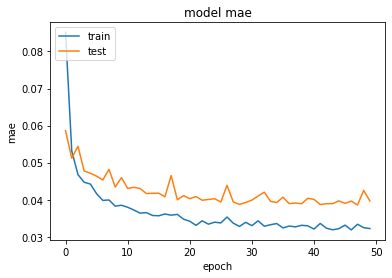

In [32]:
# summarize history for accuracy
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

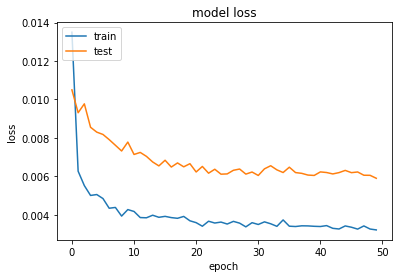

In [33]:
# Above, accuracy increase a lot in the last few epochs. Below, the loss gradually decrease. These are positive signs that our model is doing very good.

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

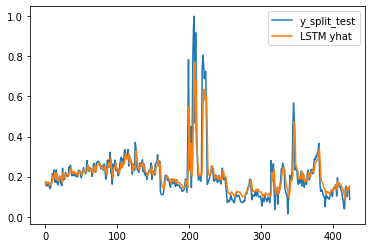

In [34]:
# plot yhat and y_split_test
plt.plot(y_split_test, label='y_split_test')
plt.plot(yhat, label='LSTM yhat')
plt.legend()

# Model Training for Ashok Vihar BiDirectional LSTM

In [35]:
from LSTM_Model import build_bidirectional_lstm_model
from keras.optimizers import Adam

n_steps = 10
n_features = 5
input_shape = (n_steps, n_features)
num_lstm_units = 64
num_dense_units = 50
dense_activation_function = 'tanh'
optimizer = Adam(lr=0.001)

B_model = build_bidirectional_lstm_model(input_shape, num_lstm_units, num_dense_units, dense_activation_function, optimizer)

#  fit model
hist = B_model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=50, verbose = 1)


Epoch 1/50


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



46/46 [==============================] - 3s 20ms/step - loss: 0.0082 - mae: 0.0589 - val_loss: 0.0098 - val_mae: 0.0530
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0045 - mae: 0.0382 - val_loss: 0.0087 - val_mae: 0.0483
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0084 - val_mae: 0.0508
Epoch 4/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0038 - mae: 0.0341 - val_loss: 0.0081 - val_mae: 0.0492
Epoch 5/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0038 - mae: 0.0342 - val_loss: 0.0077 - val_mae: 0.0460
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0077 - val_mae: 0.0443
Epoch 7/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0036 - mae: 0.0333 - val_loss: 0.0073 - val_mae: 0.0432
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0035 - mae: 0.0327 

In [36]:
B_yhat = B_model.predict(X_split_test)
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_split_test, B_yhat)
print('MSE: %.5f' % mse)
rmse = sqrt(mse)
print('RMSE: %.5f' % rmse)
# R2 score
r2 = r2_score(y_split_test, B_yhat)
print('R2: %.5f' % r2)

14/14 [==============================] - 0s 6ms/step
MSE: 0.00624
RMSE: 0.07898
R2: 0.60004


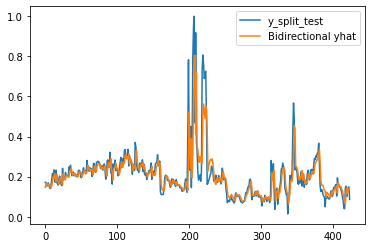

In [37]:
# plot yhat and y_split_test
plt.plot(y_split_test, label='y_split_test')
plt.plot(B_yhat, label='Bidirectional yhat')
plt.legend()

# Model Training for Ashok Vihar ML Models

In [38]:
Xml = aq_df.drop(['Ozone'], axis=1)
yml = aq_df['Ozone']
# to array

Xml = Xml.values
yml = yml.values

print(Xml)
print(yml)

[[  51.65   97.     24.56 ...    9.   2017.      8.  ]
 [  43.45   80.57   24.66 ...    9.   2017.      9.  ]
 [  70.7   139.33   24.37 ...    9.   2017.     10.  ]
 ...
 [  50.52  137.85   11.49 ...    3.   2023.     27.  ]
 [  42.73   84.37    9.3  ...    3.   2023.     28.  ]
 [  53.13  121.42    9.04 ...    3.   2023.     28.  ]]
[27.44 28.91 29.58 ... 26.99 27.92 16.64]


In [39]:
from sklearn.model_selection import train_test_split
# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xml, yml, test_size=0.3, random_state=0)

# MLR Multivariate Linear Regression Model Training for Ashok Vihar

MSE: 303.85658
RMSE: 17.43148
R2: -0.03498


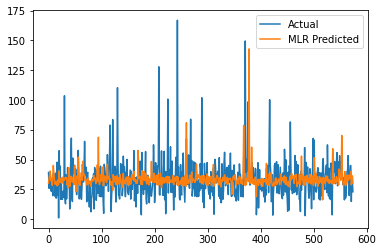

In [40]:
# write the function for the MLR model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def build_mlr_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    print('MSE: %.5f' % mse)
    rmse = sqrt(mse)
    print('RMSE: %.5f' % rmse)
    # R2 score
    r2 = r2_score(y_test, yhat)
    print('R2: %.5f' % r2)
    return model, yhat

# build the MLR model
mlr_model, mlr_yhat = build_mlr_model(X_train, y_train, X_test, y_test)

# plot yhat and y_split_test
plt.plot(y_test, label='Actual')
plt.plot(mlr_yhat, label='MLR Predicted')
plt.legend()

# Random Forest Model Training for Ashok Vihar

MSE: 137.96394
RMSE: 11.74581
R2: 0.53007


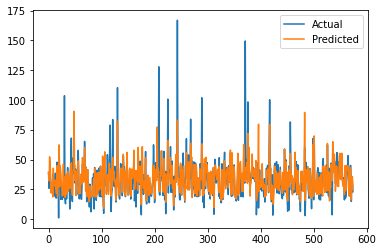

In [41]:

# write the function for the Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def build_rf_model(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    print('MSE: %.5f' % mse)
    rmse = sqrt(mse)
    print('RMSE: %.5f' % rmse)
    # R2 score
    r2 = r2_score(y_test, yhat)
    print('R2: %.5f' % r2)
    return model, yhat

# build the Random Forest model
rf_model, rf_yhat = build_rf_model(X_train, y_train, X_test, y_test)

# plot yhat and y_split_test
# plt.figure(figsize=(12, 8))
plt.plot(y_test, label='Actual')
plt.plot(rf_yhat, label='Predicted')
plt.legend()
